#Title Here

Description: Here

## 0. Inport necessary library & Set workspace

In [1]:
import os
import numpy as np
import pandas as pd

from natsort import natsorted
from datetime import datetime
from dateutil.relativedelta import relativedelta

import math
import itertools

# library for plotting
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf

from keras import backend as K
from keras.models import Model
from keras.preprocessing import sequence
from keras.utils.data_utils import Sequence
from keras.regularizers import l2
from keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix


from keras.layers import Input, Concatenate, Flatten
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

from tensorflow.keras import utils as ku 
from nltk.util import ngrams
import pickle


import keras
print(keras.__version__)


2.5.0


In [47]:
MY_WORKSPACE_DIR = os.path.join(os.getcwd(),"BPIC_11")
try:
    os.makedirs(MY_WORKSPACE_DIR)
    print("Directory " , MY_WORKSPACE_DIR ,  " created")
except:
    print("Directory " , MY_WORKSPACE_DIR ,  " already exists")

OUTPUT_DIR = os.path.join(MY_WORKSPACE_DIR, "output_files")

try:
    os.makedirs(OUTPUT_DIR)
    print("Directory " , OUTPUT_DIR ,  " created")
except:
    print("Directory " , OUTPUT_DIR ,  " already exists")

# The args dictionary is adapted from GenerativeLSTM by Manuel Camargo
# https://github.com/AdaptiveBProcess/GenerativeLSTM/blob/master/dg_training.py

args = dict()

args['processed_training_vec'] = os.path.join(OUTPUT_DIR, 'vec_training.p')
args['processed_test_vec'] = os.path.join(OUTPUT_DIR, 'vec_test.p')
args['weights'] = os.path.join(OUTPUT_DIR, 'weights.p')
args['indexes'] = os.path.join(OUTPUT_DIR, 'indexes.p')
args['args'] = os.path.join(OUTPUT_DIR, 'args.p') 

args['url'] = "https://www.win.tue.nl/bpi/lib/exe/fetch.php?media=2011:hospital_log.csv.zip"
args['log_name'] = 'bpic2011_Hospital_Data'
args['file_name'] = os.path.join(MY_WORKSPACE_DIR, 'BPIC_2011.csv') 
args['processed_file_name'] = os.path.join(OUTPUT_DIR, 'BPIC_2011_Processed.csv')
args['task']='outcome'

args['lstm_act'] = None # optimization function see keras doc
args['dense_act'] = None # optimization function see keras doc
args['n_size'] = 15 # n-gram size
args['l_size'] = 50 # LSTM layer sizes
args['norm_method'] = 'lognorm' # max, lognorm

Directory  c:\Users\mithr\Documents\GitHub\Explainable-DL-ProcessPredictionss\BPIC_11  already exists
Directory  c:\Users\mithr\Documents\GitHub\Explainable-DL-ProcessPredictionss\BPIC_11\output_files  already exists


In [3]:
args

{'processed_training_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files\\vec_training.p',
 'processed_test_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files\\vec_training.p',
 'weights': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files\\weights.p',
 'indexes': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files\\indexes.p',
 'url': 'https://www.win.tue.nl/bpi/lib/exe/fetch.php?media=2011:hospital_log.csv.zip',
 'log_name': 'bpic2011_Hospital_Data',
 'file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\BPIC_2011.csv',
 'processed_file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files\\BPIC_2011_Processed.csv',
 'task': 'outcome',
 'lstm_act': None,
 'dense_act': None,
 'n_size': 15,
 'l_size': 50,
 'no

## 1. Data Cleaning

The [raw dataset](https://www.win.tue.nl/bpi/lib/exe/fetch.php?media=2011:hospital_log.csv.zip) is from Business Processing Intelligence Challenge (BPIC) 2011. Find more information [here](https://www.win.tue.nl/bpi/doku.php?id=2011:challenge).

In [4]:
# Dataframe creation
raw_data = pd.read_csv(args['url'], compression='zip', sep=";", low_memory=False, dtype='str')
raw_data.to_csv(path_or_buf=args['file_name'],sep=';', index=False)

df = raw_data
df.shape

(150291, 128)

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,case:concept:name,event:concept:name,Treatment code,Producer code,Diagnosis,End date:10,End date:11,Diagnosis code,Number of executions,Start date:10,Start date:12,Start date:11,End date:12,End date:13,End date:14,End date:15,Specialism code:15,Specialism code:14,Specialism code:13,Specialism code:12,Diagnosis code:12,Start date:13,Diagnosis code:11,Start date:14,Start date:15,Diagnosis code:10,Specialism code:11,Specialism code:10,Treatment code:4,Treatment code:3,Diagnosis Treatment Combination ID:11,Treatment code:2,Treatment code:1,Diagnosis Treatment Combination ID:10,Diagnosis Treatment Combination ID:13,Diagnosis Treatment Combination ID:12,Diagnosis Treatment Combination ID:15,Diagnosis Treatment Combination ID:14,Treatment code:9,Treatment code:7,Treatment code:8,Treatment code:5,Treatment code:6,Treatment code:12,Treatment code:13,Treatment code:10,Treatment code:11,Treatment code:14,Treatment code:15,Specialism code:3,Start date:1,Specialism code:4,Specialism code:5,Activity code,Specialism code:6,Start date:5,Start date:4,Start date:3,Specialism code:1,Start date:2,Specialism code:2,Start date:9,Start date:8,Start date:7,Start date:6,Diagnosis:15,Diagnosis code:5,org:group,Specialism code:9,Diagnosis:14,Diagnosis code:4,Diagnosis code:3,Specialism code:7,Diagnosis code:2,Specialism code:8,Diagnosis:11,Diagnosis code:1,Diagnosis:10,Diagnosis:13,Diagnosis:12,Diagnosis code:9,Diagnosis code:8,Diagnosis code:7,Diagnosis code:6,lifecycle:transition,time:timestamp,End date,Age:5,Age:3,Age,Age:4,Diagnosis code:14,Specialism code,Diagnosis code:13,Diagnosis code:15,Diagnosis:8,Diagnosis:7,Diagnosis:6,Diagnosis:5,Diagnosis:4,Age:1,Diagnosis:3,Age:2,Diagnosis:2,Diagnosis:1,Diagnosis:9,Diagnosis Treatment Combination ID,Diagnosis Treatment Combination ID:7,Diagnosis Treatment Combination ID:8,Diagnosis Treatment Combination ID:9,Start date,Diagnosis Treatment Combination ID:6,Diagnosis Treatment Combination ID:5,Diagnosis Treatment Combination ID:4,Diagnosis Treatment Combination ID:3,Diagnosis Treatment Combination ID:2,Diagnosis Treatment Combination ID:1,End date:8,End date:7,End date:9,Section,End date:1,End date:2,End date:3,End date:4,End date:5,End date:6,Unnamed: 127
0,00000000,1e consult poliklinisch,103,SRTH,maligniteit cervix,NaN,NaN,M13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-03T00:14:24+01:00,NaN,NaN,410100,NaN,NaN,NaN,NaN,61,2005-01-03T00:14:24+01:00,61,NaN,NaN,NaN,NaN,NaN,NaN,Radiotherapy,NaN,NaN,NaN,NaN,NaN,106,NaN,NaN,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,complete,2005-01-03T00:00:00+01:00,2006-01-04T23:45:36+01:00,NaN,NaN,33,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gynaecologische tumoren,Gynaecologische tumoren,NaN,181229,NaN,NaN,NaN,2005-01-05T00:14:24+01:00,NaN,NaN,NaN,NaN,376908,376907,NaN,NaN,NaN,Section 5,2005-01-29T23:45:36+01:00,2005-01-29T23:45:36+01:00,NaN,NaN,NaN,NaN,NaN
1,00000000,administratief tarief - eerste pol,103,SRTH,maligniteit cervix,NaN,NaN,M13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-03T00:14:24+01:00,NaN,NaN,419100,NaN,NaN,NaN,NaN,61,2005-01-03T00:14:24+01:00,61,NaN,NaN,NaN,NaN,NaN,NaN,Radiotherapy,NaN,NaN,NaN,NaN,NaN,106,NaN,NaN,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,complete,2005-01-03T00:00:00+01:00,2006-01-04T23:45:36+01:00,NaN,NaN,33,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gynaecologische tumoren,Gynaecologische tumoren,NaN,181229,NaN,NaN,NaN,2005-01-05T00:14:24+01:00,NaN,NaN,NaN,NaN,376908,376907,NaN,NaN,NaN,Section 5,2005-01-29T23:45:36+01:00,2005-01-29T23:45:36+01:00,NaN,NaN,NaN,NaN,NaN
2,00000000,verlosk.-gynaec. korte kaart kosten-out,103,SGEH,maligniteit cervix,NaN,NaN,M13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Delete irrelevant attributes

From the analysis of the columns for bpic11 and the standard of event log, we can divide attributes (columns) into `Trace` attributes and `Event` attributes. The `Trace` attributes share the same values in one case. While, the `Event` attributes keep changing between activities. Here list all the attribiutes for bpic11:

- Attributes for traces (Static)
    - case:concept:name
    - Age, Age:1-15
    - ~~Diagnosis, Diagnosis:1-15~~
    - Diagnosis code, Diagnosis code:1-15
    - Treatment code, Treatment code:1-15
    - ~~Diagnosis Treatment Combination ID, Diagnosis Treatment Combination ID:1-15~~
    - ~~Specialism code, Specialism code:1-15~~
    - ~~Start date, Start date:1-15~~
    - ~~End date, End date:1-15~~

- Attributes for events (Dynamic)
    - org:group
    - Number of executions
    - ~~Specialism code~~
    - event:concept:name
    - Producer code
    - Section
    - Activity code
    - time:timestamp
    - ~~lifecycle:transition~~

All irrelevant attributes with delete line need to be droped.

In [6]:
# Clean all columns with "Diagnosis", "Diagnosis Treatment Combination ID", "Specialism code" and "lifecycle:transition"
df = df.loc[:,~df.columns.str.startswith('Diagnosis:')]
df = df.drop(columns='Diagnosis')
df = df.loc[:,~df.columns.str.startswith('Specialism code')] 
df = df.loc[:,~df.columns.str.startswith('lifecycle:transition')]
df = df.loc[:,~df.columns.str.startswith('Diagnosis Treatment Combination ID')]

df = df.loc[:,~df.columns.str.startswith('Start date')] 
df = df.loc[:,~df.columns.str.startswith('End date')]

df = df.drop(columns='Unnamed: 127')
df.shape


(150291, 46)

In [7]:
df = df.astype({'case:concept:name': 'int64', 'Number of executions': 'int64'})
df.head()

,case:concept:name,event:concept:name,Treatment code,Producer code,Diagnosis code,Number of executions,Diagnosis code:12,Diagnosis code:11,Diagnosis code:10,Treatment code:4,Treatment code:3,Treatment code:2,Treatment code:1,Treatment code:9,Treatment code:7,Treatment code:8,Treatment code:5,Treatment code:6,Treatment code:12,Treatment code:13,Treatment code:10,Treatment code:11,Treatment code:14,Treatment code:15,Activity code,Diagnosis code:5,org:group,Diagnosis code:4,Diagnosis code:3,Diagnosis code:2,Diagnosis code:1,Diagnosis code:9,Diagnosis code:8,Diagnosis code:7,Diagnosis code:6,time:timestamp,Age:5,Age:3,Age,Age:4,Diagnosis code:14,Diagnosis code:13,Diagnosis code:15,Age:1,Age:2,Section
0,0,1e consult poliklinisch,103,SRTH,M13,1,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410100,NaN,Radiotherapy,NaN,NaN,106,106,NaN,NaN,NaN,NaN,2005-01-03T00:00:00+01:00,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,Section 5
1,0,administratief tarief - eerste pol,103,SRTH,M13,1,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419100,NaN,Radiotherapy,NaN,NaN,106,106,NaN,NaN,NaN,NaN,2005-01-03T00:00:00+01:00,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,Section 5
2,0,verlosk.-gynaec. korte kaart kosten-out,103,SGEH,M13,1,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10107,NaN,Nursing ward,NaN,NaN,106,106,NaN,NaN,NaN,NaN,2005-01-05T00:00:00+01:00,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,Section 2
3,0,echografie - genitalia interna,103,SGEC,M13,1,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339486E,NaN,Obstetrics & Gynaecology clinic,NaN,NaN,106,106,NaN,NaN,NaN,NaN,2005-01-05T00:00:00+01:00,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,Section 2
4,0,1e consult poliklinisch,103,SGEH,M13,1,NaN,NaN,NaN,NaN,NaN,23,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410100,NaN,Nursing ward,NaN,NaN,106,106,NaN,NaN,NaN,NaN,2005-01-05T00:00:00+01:00,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,Section 2


### Combine repeating features to a list

In [8]:
# Sort all columns in alphabetical order

df = df.reindex(natsorted(df.columns), axis=1)
df.head()

,Activity code,Age,Age:1,Age:2,Age:3,Age:4,Age:5,Diagnosis code,Diagnosis code:1,Diagnosis code:2,Diagnosis code:3,Diagnosis code:4,Diagnosis code:5,Diagnosis code:6,Diagnosis code:7,Diagnosis code:8,Diagnosis code:9,Diagnosis code:10,Diagnosis code:11,Diagnosis code:12,Diagnosis code:13,Diagnosis code:14,Diagnosis code:15,Number of executions,Producer code,Section,Treatment code,Treatment code:1,Treatment code:2,Treatment code:3,Treatment code:4,Treatment code:5,Treatment code:6,Treatment code:7,Treatment code:8,Treatment code:9,Treatment code:10,Treatment code:11,Treatment code:12,Treatment code:13,Treatment code:14,Treatment code:15,case:concept:name,event:concept:name,org:group,time:timestamp
0,410100,33,NaN,NaN,NaN,NaN,NaN,M13,106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,SRTH,Section 5,103,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1e consult poliklinisch,Radiotherapy,2005-01-03T00:00:00+01:00
1,419100,33,NaN,NaN,NaN,NaN,NaN,M13,106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,SRTH,Section 5,103,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03T00:00:00+01:00
2,10107,33,NaN,NaN,NaN,NaN,NaN,M13,106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,SGEH,Section 2,103,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05T00:00:00+01:00
3,339486E,33,NaN,NaN,NaN,NaN,NaN,M13,106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,SGEC,Section 2,103,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05T00:00:00+01:00
4,410100,33,NaN,NaN,NaN,NaN,NaN,M13,106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,SGEH,Section 2,103,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1e consult poliklinisch,Nursing ward,2005-01-05T00:00:00+01:00


From the previous analysis, only three static `Trace` attributes - `Age`, `Diagnosis code` and `Treatment code` - contain repeating columns. Here we use functions for combining the repearting features into lists.

For three feature lists, we apply different methods to choose a suitable value.

- `Age`: Because the diagnosis and treatment for a patient may be over years, the age in one case may increase. Here we choose the latest one.

In [9]:
# function for finding last valid value
def findLastValid(x):
    list_of_last_value = []
    for index, row in x.iterrows():
        if row.last_valid_index() is None:
            list_of_last_value.append(np.nan)
        else:
            list_of_last_value.append(row[row.last_valid_index()])
    
    return list_of_last_value

Age_List = findLastValid(df.loc[:, df.columns.str.startswith('Age')])



- `Diagnosis code`: This code shows the diagnosis from doctors. In the Appendix of bpic11 winner paper by Bose and Aalst, it provides a table for distribution of cases based on diagnosis code combinations. We choose top 8 combinations ({'M13'},{'M16'},{'M11'},{'M14'},{'106'},{'822', '106'}, {'M13', '106'}, {'M13', '822', '106'}) for our experimentation in order to avoid noise and unbalanced splits. 

```bib
@inproceedings{bpic11_winner,
  title={Analysis of patient treatment procedures: The BPI Challenge case study},
  author={R. P. J. C. Bose and W. Aalst},
  year={2011}
}
```

In [10]:
# function for finding the valid value list

def findValidList(x):
    list_of_values = []
    for index, row in x.iterrows():
        values = []
        for i, v in row.items():
            if pd.notnull(v):
                values.append(v)
        # values = frozenset(values)
        list_of_values.append(values)
    return list_of_values

DiagnosisCode_List = findValidList(df.loc[:, df.columns.str.startswith('Diagnosis code')])


In [11]:
for index, value in enumerate(DiagnosisCode_List):
    DiagnosisCode_List[index] = list(set(value))
    DiagnosisCode_List[index].sort()

In [12]:
DiagnosisCode_Unique = [list(y) for y in set([tuple(x) for x in DiagnosisCode_List])]
DiagnosisCode_Unique

[['M12'],
 ['823'],
 ['106', '822', 'M14'],
 ['823', 'M14'],
 ['822'],
 ['106', '839', 'M11'],
 ['106', '839', 'M13'],
 ['106', '821', 'M13'],
 ['M15'],
 ['106', 'M13'],
 ['106', '821', 'M16'],
 ['106', 'M16'],
 ['106', 'M11'],
 ['M14'],
 ['106'],
 ['839'],
 ['821', '839', 'M16'],
 ['821'],
 ['821', '839'],
 ['106', '822', 'M13'],
 ['106', '823', 'M15'],
 ['106', 'M12'],
 ['106', '823', 'M14'],
 ['839', 'M16'],
 ['106', '821', '822'],
 ['106', '823'],
 ['106', '822'],
 ['106', 'M15'],
 ['M11'],
 ['M13'],
 ['M16'],
 ['106', 'M14'],
 ['821', 'M16'],
 ['822', 'M11'],
 ['822', 'M13'],
 ['839', 'M12'],
 ['106', '839'],
 ['106', '821']]

In [13]:
# ['106', '822'] -> ['106']
# ['106', 'M13'] -> ['106']
# ['106', '822', 'M13'] -> ['106']

Changed_Diag_Comb = [['106', '822'], ['106', 'M13'], ['106', '822', 'M13']]

for index, value in enumerate(DiagnosisCode_List):
    if value in Changed_Diag_Comb:
        DiagnosisCode_List[index] = ['106']

- `Treatment code`: Combine the repeated codes in to one list and find a most frquent one.

In [14]:
# function for finding most frequent element
def mostFrequent(x):
    list_of_values=[]
    for case in x:
        if len(case) == 0:
            list_of_values.append(None)
        else:
            list_of_values.append(max(case, key = case.count))
    return list_of_values

TreatmentCode_List = findValidList(df.loc[:, df.columns.str.startswith('Treatment code')])
TreatmentCode_List = mostFrequent(TreatmentCode_List)

### Add Additinal Features

Add time features, by calculating the time difference between the first event and the last event.

In [15]:
# Calculate week and day

# total number of traces: 1143 (Hard coding)

Month_list = []
Day_list = []

for case_id in range(1143):
    year_df = df.loc[df['case:concept:name'] == case_id]
    dateStart = datetime.strptime(year_df.iloc[0,-1], '%Y-%m-%dT%H:%M:%S%z')
    dateEnd = datetime.strptime(year_df.iloc[-1,-1], '%Y-%m-%dT%H:%M:%S%z')
    Day_list.append(abs((dateEnd - dateStart).days))
    Month_list.append(abs((dateEnd.year - dateStart.year) * 12 + (dateEnd.month - dateStart.month)))


The new dataframe should include these feaures: 

Activity, Department, Number of executions, Activitycode, Producer code, Section, Age, Diagnosis Code, Treatment code and Year.

In [16]:
processed_df = df[['case:concept:name', 'event:concept:name', 'org:group', 'time:timestamp', 'Activity code', 'Number of executions', 'Producer code', 'Section']]

processed_df = processed_df.assign(Age = Age_List)
processed_df = processed_df.assign(Diagnosis_code = DiagnosisCode_List)
processed_df = processed_df.assign(Treatment_code = TreatmentCode_List)

def input_day(row):
    return Day_list[row['case:concept:name']]

def input_month(row):
    return Month_list[row['case:concept:name']]

# case lenth
case_len_list = processed_df.groupby(['case:concept:name']).size().values
def input_cl(row):
    return case_len_list[row['case:concept:name']]

processed_df['Total month'] = processed_df.apply(lambda x: input_month(x), axis=1)
processed_df['Total day'] = processed_df.apply(lambda x: input_day(x), axis=1)
processed_df['Case Lenth'] = processed_df.apply(lambda x: input_cl(x), axis=1)

### Clean nosie in Diagnosis_code and event:concept:name

In [17]:
# clean Number of executions less than 1

processed_df = processed_df[processed_df['Number of executions'] > 0]

activity_list = processed_df['event:concept:name'].value_counts().loc[lambda x : x>19].index.tolist()
processed_df = processed_df[processed_df['event:concept:name'].isin(activity_list)]

In [18]:
# clean Treatment_code is null
processed_df = processed_df[~processed_df['Treatment_code'].isnull()]
processed_df.isnull().any()

case:concept:name       False
event:concept:name      False
org:group               False
time:timestamp          False
Activity code           False
Number of executions    False
Producer code           False
Section                 False
Age                     False
Diagnosis_code          False
Treatment_code          False
Total month             False
Total day               False
Case Lenth              False
dtype: bool

In [19]:
processed_df['Diagnosis_code'] = processed_df['Diagnosis_code'].apply(lambda x: ','.join(map(str, x)))
Selected_Diag_Comb = ['M13', 'M16', 'M11', 'M14', '106']
processed_df = processed_df[processed_df['Diagnosis_code'].isin(Selected_Diag_Comb)]



In [20]:
column_names = ['CaseID', 'Activity', 'Department', 'Timestamps', 'Activity code', 'Number of executions', 'Producer code', 'Section', 'Age', 'Diagnosis code', 'Treatment code', 'Month', 'Day', 'Case Lenth']
processed_df.columns = column_names

processed_df = processed_df.astype({'Age': 'int64'})

processed_df = processed_df.reset_index(drop=True)
processed_df.dtypes

CaseID                   int64
Activity                object
Department              object
Timestamps              object
Activity code           object
Number of executions     int64
Producer code           object
Section                 object
Age                      int64
Diagnosis code          object
Treatment code          object
Month                    int64
Day                      int64
Case Lenth               int64
dtype: object

### Save processed dataframe to csv for backup

In [21]:
processed_df.to_csv(path_or_buf=args['processed_file_name'],sep=';', index=False)

## 2. Understanding the dataset

### Loading the data and parameter files

In [22]:
log_df = processed_df
log_df.head()

,CaseID,Activity,Department,Timestamps,Activity code,Number of executions,Producer code,Section,Age,Diagnosis code,Treatment code,Month,Day,Case Lenth
0,0,1e consult poliklinisch,Radiotherapy,2005-01-03T00:00:00+01:00,410100,1,SRTH,Section 5,33,106,103,2,66,75
1,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03T00:00:00+01:00,419100,1,SRTH,Section 5,33,106,103,2,66,75
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05T00:00:00+01:00,10107,1,SGEH,Section 2,33,106,103,2,66,75
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05T00:00:00+01:00,339486E,1,SGEC,Section 2,33,106,103,2,66,75
4,0,1e consult poliklinisch,Nursing ward,2005-01-05T00:00:00+01:00,410100,1,SGEH,Section 2,33,106,103,2,66,75


### Data Analysis - Balance of Data Set

In [23]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - Diagnosis code\n')
print(log_df.groupby(['Diagnosis code'])['CaseID'].nunique())

Distribution of cases by the target variable - Diagnosis code

Diagnosis code
106    235
M11    160
M13    249
M14    102
M16    198
Name: CaseID, dtype: int64


### Create indexes
Author: Renuka Sindagatta/ Manuel Camargo

Function: creates an index (index encoded set) for a given categorical column.

In [24]:
def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    if column !='Diagnosis code':
      for i, _ in enumerate(subsec_set):
          alias[subsec_set[i]] = i + 1
    else:
      for i, _ in enumerate(subsec_set):
          alias[subsec_set[i]] = i  
    return alias

create the indexes for the processed dataframe

In [25]:
# Index creation for activity
# column_names = ['CaseID', 'Activity', 'Department', 'Timestamps', 'Activity code', 'Number of executions', 'Producer code', 'Section', 'Age', 'Diagnosis code', 'Treatment code', 'Month', 'Day']

ac_index = create_index(log_df, 'Activity')
ac_index['start'] = 0
ac_index['end'] = len(ac_index)
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for department/role

rl_index = create_index(log_df, 'Department')
rl_index['start'] = 0
rl_index['end'] = len(rl_index)
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for Diagnosis

di_index = create_index(log_df, 'Diagnosis code')

index_di = {v: k for k, v in di_index.items()}

# Index creation for Treatment
tr_index = create_index(log_df, 'Treatment code')
index_tr = {v: k for k, v in tr_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['Activity'].map(ac_index)
log_df['rl_index'] = log_df['Department'].map(rl_index)
log_df['di_index'] = log_df['Diagnosis code'].map(di_index)
log_df['tr_index'] = log_df['Treatment code'].map(tr_index)

print(rl_index)
print(index_rl)
log_df.head()




{'Anesthesiology': 1, 'Anesthesiology clinic': 2, 'Cardiovascular clinics': 3, 'Day Centre - treatment': 4, 'Day Centre - ward': 5, 'Diet Studies': 6, 'Emergency room': 7, 'Endoscopy': 8, 'Function Centre ENT': 9, 'General Lab Clinical Chemistry': 10, 'Hyper Pressure Tank': 11, 'ICU Adults': 12, 'IVF clinic': 13, 'Internal Specialisms clinic': 14, 'Lab Experimental Immunology': 15, 'Lab Hematology': 16, 'Maternity ward': 17, 'Medical Microbiology': 18, 'Nuclear Medicine': 19, 'Nursing ward': 20, 'Obstetrics & Gynaecology clinic': 21, 'Operating rooms': 22, 'Pain clinic': 23, 'Pathology': 24, 'Pharmacy Laboratory': 25, 'Radiology': 26, 'Radiotherapy': 27, 'Recovery room / high care': 28, 'Special lab Nuro sensory': 29, 'Special lab radiology': 30, 'surgery & urology clinic': 31, 'start': 0, 'end': 32}
{1: 'Anesthesiology', 2: 'Anesthesiology clinic', 3: 'Cardiovascular clinics', 4: 'Day Centre - treatment', 5: 'Day Centre - ward', 6: 'Diet Studies', 7: 'Emergency room', 8: 'Endoscopy', 

,CaseID,Activity,Department,Timestamps,Activity code,Number of executions,Producer code,Section,Age,Diagnosis code,Treatment code,Month,Day,Case Lenth,ac_index,rl_index,di_index,tr_index
0,0,1e consult poliklinisch,Radiotherapy,2005-01-03T00:00:00+01:00,410100,1,SRTH,Section 5,33,106,103,2,66,75,7,27,0,3
1,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03T00:00:00+01:00,419100,1,SRTH,Section 5,33,106,103,2,66,75,10,27,0,3
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05T00:00:00+01:00,10107,1,SGEH,Section 2,33,106,103,2,66,75,192,20,0,3
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05T00:00:00+01:00,339486E,1,SGEC,Section 2,33,106,103,2,66,75,83,21,0,3
4,0,1e consult poliklinisch,Nursing ward,2005-01-05T00:00:00+01:00,410100,1,SGEH,Section 2,33,106,103,2,66,75,7,20,0,3


### Data Analysis - Correlation between features

credits: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

<AxesSubplot:>

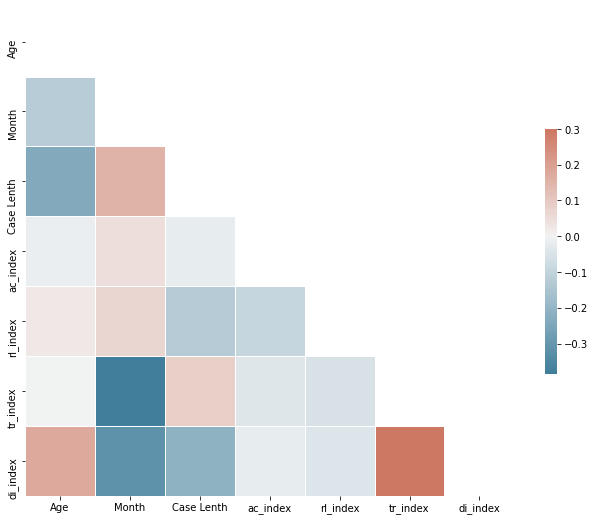

In [26]:
cor_columns = ['Age','Month','Case Lenth','ac_index','rl_index','tr_index','di_index']

d = log_df[cor_columns]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Split train test

Author: Renuka Sindagatta/ Manuel Camargo

Function: divides the dataset into test and train sets, preserving traces

In [27]:
# =============================================================================
# Split an event log dataframe to peform split-validation 
# =============================================================================
def split_train_test(df, percentage):
    cases = df.CaseID.unique()
    num_test_cases = int(np.round(len(cases)*percentage))
    test_cases = cases[:num_test_cases]
    train_cases = cases[num_test_cases:]
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    for case in train_cases:
        df_train = df_train.append(df[df.CaseID==case]) 
    df_train = df_train.sort_values('Timestamps', ascending=True).reset_index(drop=True)
 
    for case in test_cases:
        df_test = df_test.append(df[df.CaseID==case]) 
    df_test = df_test.sort_values('Timestamps', ascending=True).reset_index(drop=True)
    
    return df_train, df_test 

splitting the dataframe into test and train sets

In [28]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

### normalize_events

Modified from the function of: Renuka Sindagatta/ Manuel Camargo

Function: Normalizes the numerical features

In [29]:
def normalize_events(log_df,args,features):

#log_df(DataFrame): The dataframe with eventlog data
#args(Dictionary): The set of parameters
#Returns a Dataframe with normalized numerical features
  for feature in features:
    if args['norm_method'] == 'max':
        mean_feature = np.mean(log_df.feature)
        std_feature = np.std(log_df.feature)
        norm = lambda x: (x[feature]-mean_feature)/std_feature
        log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
    elif args['norm_method'] == 'lognorm':
        logit = lambda x: math.log1p(x[feature])
        log_df['%s_log'%(feature)] = log_df.apply(logit, axis=1)
        mean_feature = np.mean(log_df['%s_log'%(feature)])
        std_feature=np.std(log_df['%s_log'%(feature)])
        norm = lambda x: (x['%s_log'%(feature)]-mean_feature)/std_feature
        log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
  return log_df

Adding normalized features: to the training set

In [30]:
numerical_features = ['Age','Month', 'Day', 'Case Lenth']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)
log_df_train.head()

,CaseID,Activity,Department,Timestamps,Activity code,Number of executions,Producer code,Section,Age,Diagnosis code,Treatment code,Month,Day,Case Lenth,ac_index,rl_index,di_index,tr_index,Age_log,Age_norm,Month_log,Month_norm,Day_log,Day_norm,Case Lenth_log,Case Lenth_norm
0,341,ligdagen - alle spec.beh.kinderg.-reval.,Nursing ward,2005-07-25T01:00:00+02:00,40014,1,H5ZU,Section 2,59,M16,101,31,934,307,125,20,4,1,4.094345,0.425742,3.465736,1.40527,6.840547,1.184411,5.7301,0.174067
1,341,190205 klasse 3b a205,Nursing ward,2005-07-25T01:00:00+02:00,613000,1,H5ZU,Section 2,59,M16,101,31,934,307,5,20,4,1,4.094345,0.425742,3.465736,1.40527,6.840547,1.184411,5.7301,0.174067
2,341,190021 klinische opname a002,Nursing ward,2005-07-25T01:00:00+02:00,610001,1,H5ZU,Section 2,59,M16,101,31,934,307,1,20,4,1,4.094345,0.425742,3.465736,1.40527,6.840547,1.184411,5.7301,0.174067
3,341,ordertarief,General Lab Clinical Chemistry,2005-07-25T01:00:00+02:00,379999,1,CRLA,Section 4,59,M16,101,31,934,307,147,10,4,1,4.094345,0.425742,3.465736,1.40527,6.840547,1.184411,5.7301,0.174067
4,341,ca-19.9 tumormarker,General Lab Clinical Chemistry,2005-07-25T01:00:00+02:00,379414,1,CHE1,Section 4,59,M16,101,31,934,307,42,10,4,1,4.094345,0.425742,3.465736,1.40527,6.840547,1.184411,5.7301,0.174067


In [31]:
training_traces = len(log_df_train['CaseID'].unique())
test_traces = len(log_df_test['CaseID'].unique())

print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))

Number of traces in training set is:661
Number of traces in test set is:283


In [32]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['Diagnosis code'])['CaseID'].nunique())

print('test dataset')
print(log_df_test.groupby(['Diagnosis code'])['CaseID'].nunique())



training dataset
Diagnosis code
106    161
M11    101
M13    176
M14     83
M16    140
Name: CaseID, dtype: int64
test dataset
Diagnosis code
106    74
M11    59
M13    73
M14    19
M16    58
Name: CaseID, dtype: int64


### Reformat events

Modified from the function of: Renuka Sindagatta/ Manuel Camargo

Function: converts the dataframe into a dictionary, using the indexes created

In [33]:
# ==============================================================================
# Reformat events: converts the dataframe into a numerical dictionary
# ==============================================================================

def reformat_events(log_df, ac_index, rl_index,di_index):
    """Creates series of activities, roles and relative times per trace.
    Args:
        log_df: dataframe.
        ac_index (dict): index of activities.
        rl_index (dict): index of roles.
    Returns:
        list: lists of activities, roles and relative times.
    """
    log_df = log_df.to_dict('records')

    temp_data = list()
    log_df = sorted(log_df, key=lambda x: (x['CaseID'], x['Timestamps']))
    for key, group in itertools.groupby(log_df, key=lambda x: x['CaseID']):
        trace = list(group)
        #dynamic features
        ac_order = [x['ac_index'] for x in trace]
        rl_order = [x['rl_index'] for x in trace]

        #static features: the aggregation used is max(), however, any aggregation could be used since we have a single value for this for the whole trace
        age = max(x['Age_norm'] for x in trace)
        months = max(x['Month_norm'] for x in trace)
        case_len = max(x['Case Lenth_norm'] for x in trace)

        #outcome
        diagnosis = max(x['di_index'] for x in trace)

        #Adding start and end to the dynamic features
        ac_order.insert(0, ac_index[('start')])
        ac_order.append(ac_index[('end')])
        rl_order.insert(0, rl_index[('start')])
        rl_order.append(rl_index[('end')])
        temp_dict = dict(caseid=key,
                         ac_order=ac_order,
                         rl_order=rl_order,
                         age=age,
                         months=months,
                         case_len= case_len,
                         diagnosis = diagnosis)
        temp_data.append(temp_dict)

    return temp_data


converting the training dataframe into a dictionary


In [34]:
log_train = reformat_events(log_df_train, ac_index, rl_index,di_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,di_index)

In [35]:
#print a sample of the dictionary
print(log_train[111])

{'caseid': 468, 'ac_order': [0, 143, 16, 58, 182, 92, 29, 30, 8, 8, 8, 192, 115, 12, 158, 147, 170, 7, 10, 43, 166, 137, 161, 163, 34, 157, 94, 123, 176, 90, 140, 8, 8, 8, 10, 7, 147, 122, 177, 94, 75, 20, 58, 183, 152, 147, 147, 65, 62, 7, 10, 8, 176, 115, 143, 57, 98, 182, 92, 8, 8, 114, 47, 178, 123, 184, 125, 125, 1, 1, 5, 3, 3, 4, 3, 125, 125, 33, 189, 7, 4, 5, 3, 73, 147, 4, 5, 3, 3, 125, 125, 8, 182, 143, 57, 115, 3, 3, 4, 125, 125, 5, 125, 125, 8, 8, 183, 58, 142, 15, 117, 94, 177, 122, 147, 4, 5, 3, 3, 8, 177, 147, 193, 122, 8, 58, 15, 94, 75, 142, 117, 8, 193, 147, 184, 123, 57, 159, 8, 8, 147, 98, 176, 104, 168, 24, 2, 170, 147, 147, 34, 2, 147, 91, 157, 147, 8, 8, 8, 8, 8, 8, 8, 160, 57, 58, 142, 117, 20, 20, 20, 70, 147, 75, 158, 184, 122, 121, 121, 177, 94, 70, 91, 2, 2, 70, 70, 122, 8, 8, 58, 75, 94, 147, 147, 123, 57, 98, 8, 8, 121, 121, 57, 143, 115, 34, 157, 75, 123, 158, 91, 91, 2, 147, 176, 8, 8, 70, 98, 8, 147, 123, 57, 98, 8, 8, 70, 8, 8, 8, 57, 143, 115, 157, 123

#### Support Function 7: Vectorization
Author: Bemali Wickramanayake

Inspired by the code of: Renuka Sindagatta

Function: Creating the Input and Output Tensors 

Notes: Editing needs to finish for this function

In [36]:
# Support function for Vectirization

# This function returns the maximum trace length (trc_len), and the number of cases for train and test sets (cases)
# The maximum out of trc_len for train and test sets will be used to define the trace length of the dataset that is fed to lstm

def lengths (log):
  trc_len = 1
  cases = 1

  for i,_ in enumerate(log):

    if trc_len <len(log[i]['ac_order']):

        trc_len = len(log[i]['ac_order'])
        cases += 1
    else:
        cases += 1

  return trc_len, cases


In [37]:
#Obtain the trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)

trc_len = trc_len_train
if trc_len < trc_len_test:
  trc_len = trc_len_test

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test))

trace_length: 1791, training cases: 662, test cases: 284


In [38]:
def vectorization(log, ac_index, rl_index, di_index,trc_len,cases):

#Example function with types documented in the docstring.
#Args:
        #log: event log data in a dictionary.
        #ac_index (dict): index of activities.
        #rl_index (dict): index of roles (departments).
        #di_index (dict) : index of diagnosis codes.

#Returns:vec: Dictionary that contains all the LSTM inputs. """

  vec = {'prefixes':dict(), 'static':dict(),'diagnosis':[]} 
  len_ac = trc_len  

  for i ,_ in enumerate(log):
  
    padding = np.zeros(len_ac-len(log[i]['ac_order']))

    if i == 0:
            vec['prefixes']['x_ac_inp'] = np.array(np.append(log[i]['ac_order'],padding))
            vec['prefixes']['x_rl_inp'] = np.array(np.append(log[i]['rl_order'],padding))
            # vec['prefixes']['xt_inp'] = np.array(np.append(log[i]['tbtw'],padding))
            vec['static']['x_age_inp'] = np.array(log[i]['age'])
            vec['static']['x_months_inp'] = np.array(log[i]['months'])
            vec['static']['x_cl_inp'] = np.array(log[i]['case_len'])
            vec['diagnosis'] = np.array(log[i]['diagnosis'])


            #print(len(vec['prefixes']['x_ac_inp']))

  
    vec['prefixes']['x_ac_inp'] = np.concatenate((vec['prefixes']['x_ac_inp'],
                                                          np.array(np.append(log[i]['ac_order'],padding))), axis=0)
    vec['prefixes']['x_rl_inp'] = np.concatenate((vec['prefixes']['x_rl_inp'],
                                                          np.array(np.append(log[i]['rl_order'],padding))), axis=0)
    # vec['prefixes']['xt_inp'] = np.concatenate((vec['prefixes']['xt_inp'],
    #                                                     np.array(np.append(log[i]['tbtw'],padding))), axis=0)
    vec['static']['x_age_inp'] = np.append(vec['static']['x_age_inp'],log[i]['age'])
    vec['static']['x_months_inp'] = np.append(vec['static']['x_months_inp'],log[i]['months'])
    vec['static']['x_cl_inp'] = np.append(vec['static']['x_cl_inp'],log[i]['case_len'])
    vec['diagnosis'] = np.append(vec['diagnosis'],log[i]['diagnosis'])
  

  

  
  #The concatenation returns a flattened vector. Hence, reshaping the vectors at the end
  vec['prefixes']['x_ac_inp'] = np.reshape(vec['prefixes']['x_ac_inp'],(cases,len_ac))
  vec['prefixes']['x_rl_inp'] = np.reshape(vec['prefixes']['x_rl_inp'],(cases,len_ac))
#   vec['prefixes']['xt_inp'] = np.reshape(vec['prefixes']['xt_inp'],(cases,len_ac))

  #one-hot-encoding the y class
  vec['diagnosis'] = ku.to_categorical(vec['diagnosis'],
                                               num_classes=len(di_index))

  return vec


converting the training log (dictionary) into a Tensor

In [39]:
vec_train = vectorization(log_train,ac_index,rl_index,di_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index,rl_index,di_index,trc_len,cases_test)

In [40]:
vec_train['diagnosis']

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### Initial Embedding weights for the Embedding layer

In [41]:
# Load embedded matrix
ac_weights = ku.to_categorical(sorted(index_ac.keys()), len(ac_index))
#print('AC_WEIGHTS', ac_weights)
rl_weights =  ku.to_categorical(sorted(index_rl.keys()), len(rl_index))
#print('RL_WEIGHTS', rl_weights)


### Saving the Processed Tensor and Other Support Data

In [42]:
# args['processed_training_vec'] = vec_train
# args['processed_test_vec'] = vec_test


# # converting the weights into a dictionary and saving
# weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'diagnoses':len(di_index)}
# args['weights'] = weights

# indexes = {'index_ac':index_ac, 'index_rl':index_rl, 'index_di':index_di}
# args['indexes'] = indexes


In [48]:

# saving the processed tensor
with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'diagnoses':len(di_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl, 'index_di':index_di}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)




## 3. Dynamic Features with Attention

## 4. Dynamic and Static Features with Attention